# Semantic Segmentation from small training set using Transfer Learning for Feature Extraction
This is an example of Transfer Learning to extract features for a Semantic Segmentation problem.

Labeling is a process that is hard, and expensive (in time, money, resources). The problem I'm trying to solve here is to use the smallest amount of training data possible to come up is a model that can segment the images correctly.

In order to do this, I'm using a technique called *Transfer Learning*. I dissected a previously fully train model used in image classification (VGG16) and using it to extract features from the images. Then, I built a standard Random Forest Classifier to classify these features using as target classes, the classes of the masks in the training set.

The inferece is done in a similar way, using the trimmed VGG16 model to extract the features of the image, and then classifying the features using the RF fitted model.

I'm using the [EPFL Electron Microscopy Dataset](https://www.epfl.ch/labs/cvlab/data/data-em/) and training using only 10 images.

Spoiler alert: the results are 💩💩💩💩

**TODO**: Check why the results are so bad and find a way to fix it
* Idea: Add an extra target class, using the missclassified pixels from this model to train a new RF more capable RF.

## Imports and Data loading and preprocessing

In [1]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential, Model
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

2024-02-08 18:02:31.321522: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 18:02:31.948554: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SIZE_X = 1024
SIZE_Y = 768
# Number of images of the training set to use for training.
number_of_images = 10

In [3]:
train_images = []
train_masks = []

for i in range(number_of_images):
    img = keras.utils.load_img(f'images/mito_train/train_{i:03d}.tif')
    img = keras.utils.img_to_array(img)
    img = preprocess_input(img)
    train_images.append(img)
    img = keras.utils.load_img(f'images/mito_train/train_{i:03d}_mask.tif')
    img = keras.utils.img_to_array(img)
    #img = preprocess_input(img)  # no need to preprocess the masks.
    train_masks.append(img)
train_images = np.array(train_images)
train_masks = np.array(train_masks)

In [4]:
train_images;

## Model trimming
#### 1. Load the VGG16 model and pre-trained weights

In [5]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_Y,SIZE_X,3))

2024-02-08 18:02:33.445771: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:992] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-08 18:02:33.451411: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
VGG_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 768, 1024, 3)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 768, 1024, 64)     │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 768, 1024, 64)     │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 384, 512, 64)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 384, 512, 128)     │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 384, 512, 128)     │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 192, 256, 128)     │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 192, 256, 256)     │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 192, 256, 256)     │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 192, 256, 256)     │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 96, 128, 256)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 96, 128, 512)      │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 96, 128, 512)      │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 96, 128, 512)      │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 48, 64, 512)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 48, 64, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 48, 64, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 48, 64, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 24, 32, 512)       │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### 2. Set the model to read-only, as we are not going to train the model

In [7]:
for layer in VGG_model.layers:
    layer.trainable = False

In [8]:
VGG_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 768, 1024, 3)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 768, 1024, 64)     │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 768, 1024, 64)     │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 384, 512, 64)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 384, 512, 128)     │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 384, 512, 128)     │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 192, 256, 128)     │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 192, 256, 256)     │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 192, 256, 256)     │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 192, 256, 256)     │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 96, 128, 256)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 96, 128, 512)      │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 96, 128, 512)      │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 96, 128, 512)      │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 48, 64, 512)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 48, 64, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 48, 64, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 48, 64, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 24, 32, 512)       │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

#### 3. Create a new model with the first 3 layers of the VGG16

In [9]:
model = Model(inputs=VGG_model.inputs, outputs=VGG_model.get_layer('block1_conv2').output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 768, 1024, 3)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 768, 1024, 64)     │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 768, 1024, 64)     │     36,928 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 38,720 (151.25 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 38,720 (151.25 KB)

#### 4. Extract the features of the images

In [10]:
features = model.predict(train_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [11]:
features.shape

(10, 768, 1024, 64)

#### 5. Plot the extracted features of one image

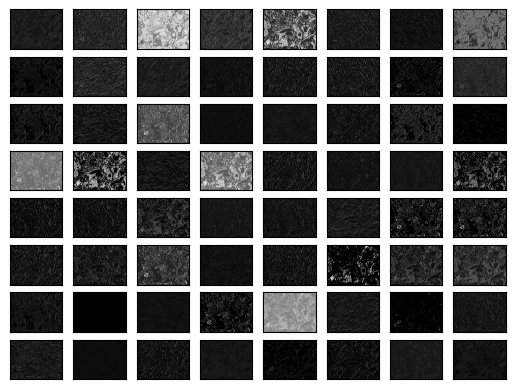

In [12]:
# Show the features
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square,square,ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1],cmap='gray')
        ix += 1
        

## Random Forest Model training
#### 1. Prepare the features
The features need to be squashed into s single dimension in order to be fed to the RF model. For each pixel of the image, 64 features are extracted.

In [13]:
X = features
X = X.reshape(-1, X.shape[3])
X.shape

(7864320, 64)

In [14]:
Y = train_masks[:,:,:,0].reshape(-1).astype(np.uint8)
Y.shape

(7864320,)

#### 2. A random sample of the features is used to train.

In [15]:
dataset = pd.DataFrame(X)
dataset['label'] = Y
nsamples = 50000
dataset = pd.concat([dataset[dataset.label != 0].sample(nsamples), dataset[dataset.label == 0].sample(nsamples)]).sample(nsamples*2)

In [16]:
X_for_RF = dataset.drop(labels=['label'],axis=1)
# The masks are binarized.
Y_for_RF = (dataset.label == 255).astype(int)

In [17]:
Y_for_RF;

#### 3. Model definition

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=250,  n_jobs=12, random_state=42)

#### 4. Model fit

In [19]:
rfc.fit(X_for_RF, Y_for_RF)

RandomForestClassifier(n_estimators=250, n_jobs=12, random_state=42)

#### 5. Save the models for future use

In [20]:
import pickle
pickle.dump(rfc, open('models/RandomForestCls.model', 'wb'))  # it generates a 1.3GB pickle file :S
model.save('models/VGG16_feature_extractor.keras')

## Testing the segmentation model

#### 1. Load saved models

In [21]:
model_feature_extr = keras.models.load_model('models/VGG16_feature_extractor.keras')
model_RF_cls = pickle.load(open('models/RandomForestCls.model', 'rb'))  # you need to fit the model yourself, it's a 1.3GB pickle

#### 2. Load test images and ground truth masks

In [22]:
test_images = []
test_gtruth = []

number_of_images = 30

for i in range(number_of_images):
    img = keras.utils.load_img(f'images/mito_test/test_{i:03d}.tif')
    img = keras.utils.img_to_array(img)
    img = preprocess_input(img)
    test_images.append(img)
    img = keras.utils.load_img(f'images/mito_test/test_{i:03d}_groundtruth.tif')
    img = keras.utils.img_to_array(img)
    test_gtruth.append(img)
test_images = np.array(test_images)
test_gtruth = np.array(test_gtruth)

#### 3. Predict the features using the trimmed VGG16 model

In [23]:
features = model_feature_extr.predict(test_images)
X = features
X = X.reshape(-1, X.shape[3])
X.shape

2024-02-08 18:03:12.535609: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6039797760 exceeds 10% of free system memory.
2024-02-08 18:03:14.037825: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6039797760 exceeds 10% of free system memory.


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


(23592960, 64)

#### 4. Predict the segments using the  RF classifier

In [24]:
prediction = model_RF_cls.predict(X)

In [25]:
prediction.shape

(23592960,)

In [26]:
prediction = prediction.reshape(test_images.shape[:3])

#### 5. Plot the predictions

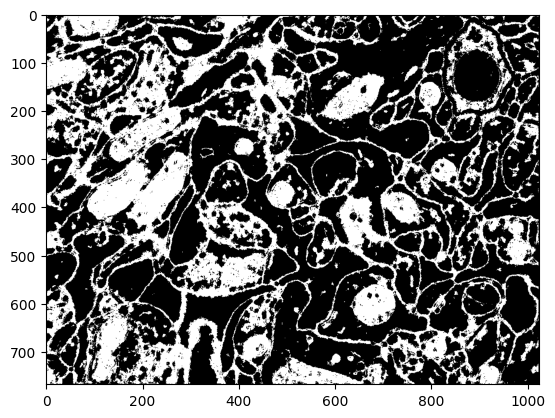

In [27]:
plt.imshow(prediction[0],cmap='binary_r')

#### 6. And the ground truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


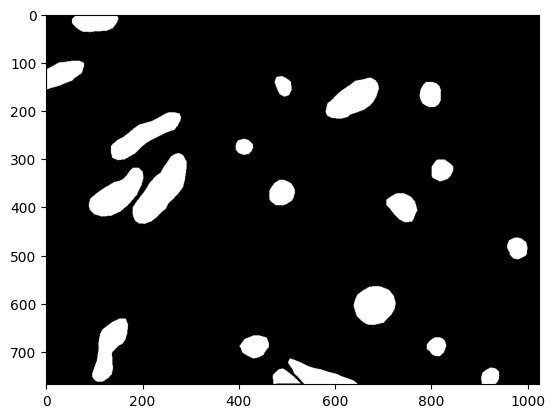

In [28]:
plt.imshow(test_gtruth[0])

## Measure the performance of the segmentation model

In [29]:
from sklearn.metrics import mean_absolute_error,accuracy_score,f1_score

In [30]:
mae = []
acc = []
for idx in range(number_of_images):
    mae.append(mean_absolute_error((test_gtruth[idx,:,:,0] == 255).astype(int).reshape(-1),prediction[idx].reshape(-1)))
    acc.append(accuracy_score((test_gtruth[idx,:,:,0] == 255).astype(int).reshape(-1),prediction[idx].reshape(-1)))

In [31]:
print(f'Mean ACC:           {np.mean(acc):0.4f}⁺∕₋{np.std(acc):.4f}')
print(f'Mean MAE:           {np.mean(mae):0.4f}⁺∕₋{np.std(mae):.4f}')

Mean ACC:           0.7245⁺∕₋0.0075
Mean MAE:           0.2755⁺∕₋0.0075
